In [3]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [7]:
data_path = os.path.join("data", r"C:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\data\jse_stocks.csv")
prices = pd.read_csv(data_path, index_col=0, parse_dates=True)


In [8]:
print(prices.columns[:5])  
print(prices.index[:5])    
print(prices.head())       


Index(['AGL.JO', 'AMS.JO', 'ANG.JO', 'GFI.JO', 'IMP.JO'], dtype='object')
DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
                  AGL.JO        AMS.JO        ANG.JO       GFI.JO  \
Date                                                                
2000-01-04   9743.161133  17986.937500  15174.217773  2468.641846   
2000-01-05   9743.161133  17098.218750  15174.217773  2315.718262   
2000-01-06  10090.876953  16885.699219  15174.217773  2280.763916   
2000-01-07  10110.500977  16615.222656  15174.217773  2280.763916   
2000-01-10  10511.900391  17001.621094  15174.217773  2398.733398   

                 IMP.JO       SOL.JO       GLN.JO       SSW.JO       SBK.JO  \
Date                                                                          
2000-01-04  3031.447998  4868.092285  5374.757324  4714.452148  2471.444824   
2000-01-05  2898.595215  4863.135742  5374

## Régression simple

                            OLS Regression Results                            
Dep. Variable:                 GFI.JO   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     877.4
Date:                Sat, 17 May 2025   Prob (F-statistic):          5.94e-181
Time:                        18:13:13   Log-Likelihood:                -66120.
No. Observations:                6486   AIC:                         1.322e+05
Df Residuals:                    6484   BIC:                         1.323e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5971.6752    156.297     38.207      0.0

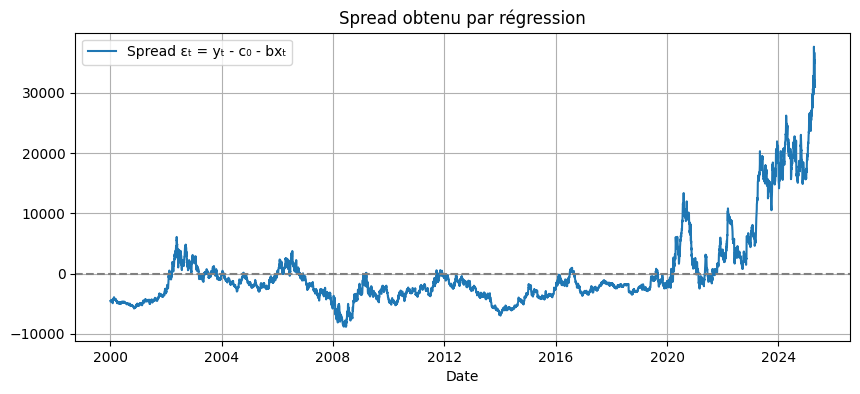

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

x = prices["IMP.JO"]
y = prices["GFI.JO"]  

df_pair = pd.concat([x, y], axis=1).dropna()
x_clean = df_pair["IMP.JO"]
y_clean = df_pair["GFI.JO"]

X = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X).fit()

df_pair["spread"] = model.resid

print(model.summary())

plt.figure(figsize=(10, 4))
plt.plot(df_pair.index, df_pair["spread"], label="Spread εₜ = yₜ - c₀ - bxₜ")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Spread obtenu par régression")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


## test ADF

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_pair["spread"])
print(f"ADF Stat: {result[0]}")
print(f"p-value : {result[1]}")
print("Critères de rejet :")
for key, val in result[4].items():
    print(f"  {key}: {val}")


ADF Stat: 0.8489037255518106
p-value : 0.9923859279561076
Critères de rejet :
  1%: -3.4313625212742105
  5%: -2.8619874471870737
  10%: -2.567008172846683


## fonction pour selectionner les paires co integrée 

In [12]:
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import pandas as pd

def detect_cointegrated_pairs(prices_df, max_pairs=None):
    tickers = prices_df.columns
    results = []

    pairs = list(itertools.combinations(tickers, 2))
    if max_pairs:
        pairs = pairs[:max_pairs]  # pour tester sur un sous-ensemble

    for t1, t2 in pairs:
        pair_df = prices_df[[t1, t2]].dropna()

        if len(pair_df) < 100:  # trop peu d'observations ?
            continue

        x = pair_df[t1]
        y = pair_df[t2]
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        spread = model.resid

        try:
            adf_stat, pval, _, _, crit_vals, _ = adfuller(spread)
            results.append({
                "X": t1,
                "Y": t2,
                "ADF Stat": adf_stat,
                "p-value": pval,
                "1% crit": crit_vals["1%"],
                "5% crit": crit_vals["5%"],
                "R²": model.rsquared
            })
        except Exception as e:
            print(f"Erreur sur la paire {t1}-{t2}: {e}")
            continue

    # transformer en DataFrame et filtrer
    df_results = pd.DataFrame(results)
    df_results = df_results[df_results["p-value"] < 0.05].sort_values("p-value")
    return df_results.reset_index(drop=True)


In [13]:
cointegrated_pairs = detect_cointegrated_pairs(prices, max_pairs=100)
print(cointegrated_pairs.head(10))

        X       Y  ADF Stat   p-value   1% crit   5% crit        R²
0  AMS.JO  MCG.JO -5.083679  0.000015 -3.431363 -2.861988  0.218871
1  AGL.JO  MCG.JO -4.912369  0.000033 -3.431364 -2.861988  0.122515
2  ANG.JO  GFI.JO -3.340469  0.013164 -3.431359 -2.861986  0.747838
3  AGL.JO  DCP.JO -3.296197  0.015049 -3.431359 -2.861986  0.326254
4  AGL.JO  PRX.JO -3.241963  0.017681 -3.431364 -2.861988  0.067189
5  AMS.JO  PPH.JO -3.136345  0.023978 -3.431363 -2.861987  0.112773
6  AMS.JO  PRX.JO -3.004866  0.034442 -3.431364 -2.861988  0.030620
7  AGL.JO  AMS.JO -2.901583  0.045164 -3.431364 -2.861988  0.756888


## Régression et extraction du spread

In [14]:
import pandas as pd
import statsmodels.api as sm

# Sélection des prix
x = prices["GFI.JO"]
y = prices["ANG.JO"]

# Nettoyage
df_pair = pd.concat([x, y], axis=1).dropna()
x_clean = df_pair["GFI.JO"]
y_clean = df_pair["ANG.JO"]

# Régression linéaire y = c0 + b x
X = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X).fit()
spread = model.resid

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 ANG.JO   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                 1.923e+04
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        18:20:43   Log-Likelihood:                -64697.
No. Observations:                6486   AIC:                         1.294e+05
Df Residuals:                    6484   BIC:                         1.294e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.244e+04    113.240    109.862      0.0

## Définir le modèle en espace d’état (Kalman Filter)

In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

mod = UnobservedComponents(endog=spread, level='rwdrift', autoregressive=1)


res = mod.fit(disp=False)
print(res.summary())


c:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                          Unobserved Components Results                           
Dep. Variable:                          y   No. Observations:                 6486
Model:             random walk with drift   Log Likelihood              -49531.943
                                  + AR(1)   AIC                          99069.887
Date:                    Sat, 17 May 2025   BIC                          99090.218
Time:                            18:21:15   HQIC                         99076.920
Sample:                                 0                                         
                                   - 6486                                         
Covariance Type:                      opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level    2.5e+05    1.5e+04     16.686      0.000    2.21e+05    2.79e+05
sigma2.ar 

## Visualisation des composantes estimées

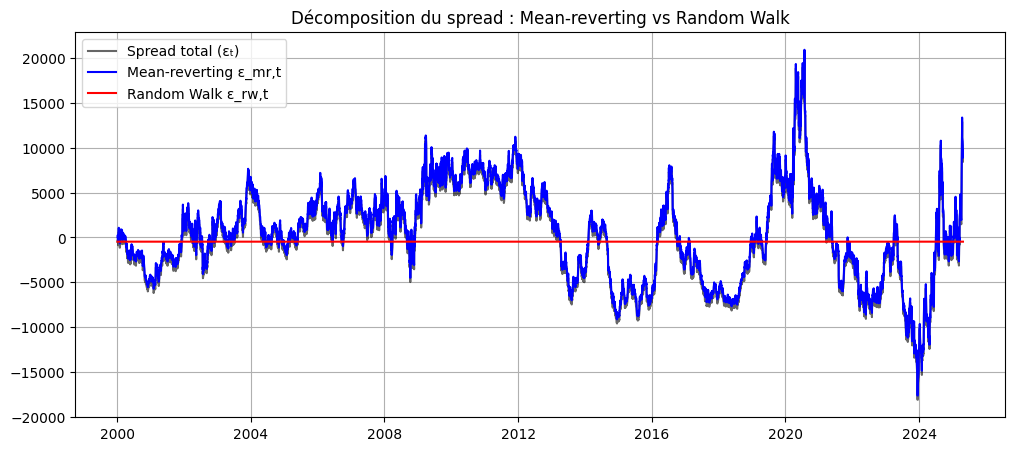

In [16]:
import matplotlib.pyplot as plt

states = res.level.smoothed  # Random walk + drift estimé
mean_reverting = res.filter_results.filtered_state[0]  # composante AR(1)

plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread, label='Spread total (εₜ)', color='black', alpha=0.6)
plt.plot(spread.index, mean_reverting, label='Mean-reverting ε_mr,t', color='blue')
plt.plot(spread.index, spread - mean_reverting, label='Random Walk ε_rw,t', color='red')
plt.title("Décomposition du spread : Mean-reverting vs Random Walk")
plt.legend()
plt.grid(True)
plt.show()


## Générer les signaux de trading

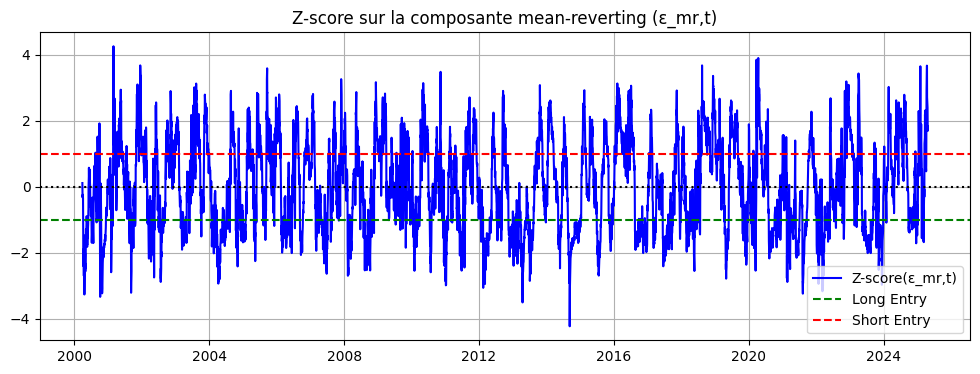

In [17]:
# Calcul du z-score sur ε_mr,t
mean_reverting_series = pd.Series(mean_reverting, index=spread.index)
z_score = (mean_reverting_series - mean_reverting_series.rolling(60).mean()) / mean_reverting_series.rolling(60).std()

# Signaux
entry_long = z_score < -1
entry_short = z_score > 1
exit = abs(z_score) < 0.1

# Visualisation des signaux
plt.figure(figsize=(12, 4))
plt.plot(z_score, label='Z-score(ε_mr,t)', color='blue')
plt.axhline(-1, color='green', linestyle='--', label='Long Entry')
plt.axhline(1, color='red', linestyle='--', label='Short Entry')
plt.axhline(0, color='black', linestyle=':')
plt.title("Z-score sur la composante mean-reverting (ε_mr,t)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Définir les signaux de position à partir du z-score
position = pd.Series(0, index=z_score.index)
position[z_score < -1] = 1   # Long
position[z_score > 1] = -1   # Short

# Sortie de position si retour vers zéro
exit_condition = (z_score > -0.1) & (z_score < 0.1)
position[exit_condition] = 0

# Propager la dernière position jusqu'à changement
position = position.replace(to_replace=0, method='ffill').fillna(0)


C:\Users\lbenzemma\AppData\Local\Temp\ipykernel_24028\1510998878.py:11: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = position.replace(to_replace=0, method='ffill').fillna(0)


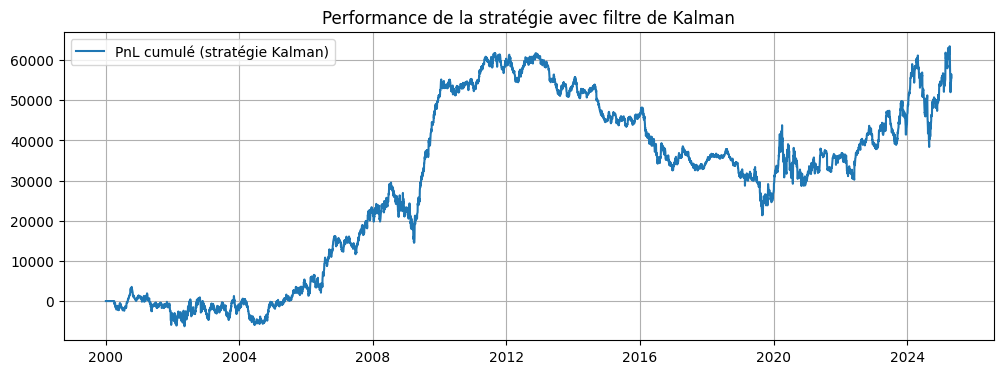

In [20]:
spread_ret = mean_reverting_series.diff()
pnl = position.shift(1) * spread_ret
cumulative_pnl = pnl.cumsum()

# Visualisation
plt.figure(figsize=(12, 4))
plt.plot(cumulative_pnl, label="PnL cumulé (stratégie Kalman)")
plt.title("Performance de la stratégie avec filtre de Kalman")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recalcul du z-score sur ε_mr,t (mean_reverting déjà estimé)
mean_reverting_series = pd.Series(mean_reverting, index=spread.index)

# Rolling moyenne et écart-type
rolling_mean = mean_reverting_series.rolling(60).mean()
rolling_std = mean_reverting_series.rolling(60).std()

z_score = (mean_reverting_series - rolling_mean) / rolling_std

# Paramètres
entry_threshold = 1.25
exit_threshold = 0.1
stop_loss_threshold = 3  # en multiples d'écart-type

# Définition des signaux
entry_long = z_score < -entry_threshold
entry_short = z_score > entry_threshold
exit_position = z_score.abs() < exit_threshold


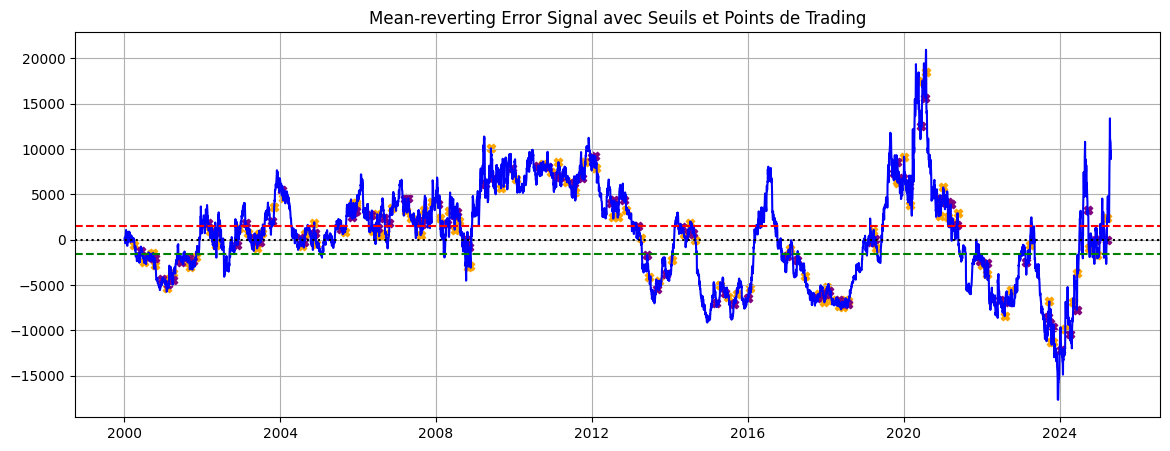

In [23]:
# Initialisation
entry_points = []
exit_points = []
position = 0  # 0 = out, 1 = long, -1 = short

for t in range(1, len(z_score)):
    if position == 0:
        if z_score.iloc[t] < -entry_threshold:
            position = 1
            entry_points.append((z_score.index[t], mean_reverting_series.iloc[t]))
        elif z_score.iloc[t] > entry_threshold:
            position = -1
            entry_points.append((z_score.index[t], mean_reverting_series.iloc[t]))
    elif position == 1:
        if abs(z_score.iloc[t]) < exit_threshold:
            position = 0
            exit_points.append((z_score.index[t], mean_reverting_series.iloc[t]))
    elif position == -1:
        if abs(z_score.iloc[t]) < exit_threshold:
            position = 0
            exit_points.append((z_score.index[t], mean_reverting_series.iloc[t]))

# Affichage du graphique avec les signaux
plt.figure(figsize=(14, 5))
plt.plot(mean_reverting_series, label="Mean-reverting error signal ε_mr,t", color='blue')
plt.axhline(entry_threshold * rolling_std.mean(), color='red', linestyle='--', label="Upper Entry Threshold")
plt.axhline(-entry_threshold * rolling_std.mean(), color='green', linestyle='--', label="Lower Entry Threshold")
plt.axhline(0, color='black', linestyle=':')

# Points d'entrée
for x, y in entry_points:
    plt.scatter(x, y, color='orange', marker='X', label='Entry Point')
# Points de sortie
for x, y in exit_points:
    plt.scatter(x, y, color='purple', marker='X', label='Exit Point')

plt.title("Mean-reverting Error Signal avec Seuils et Points de Trading")
plt.grid(True)
plt.show()


In [24]:
# Initialisation
trades = []
position = 0
entry_date = None
entry_price = None

z = z_score.copy()

for t in range(1, len(z)):
    date = z.index[t]
    price = mean_reverting_series.iloc[t]

    if position == 0:
        if z.iloc[t] < -entry_threshold:
            position = 1
            entry_price = price
            entry_date = date
        elif z.iloc[t] > entry_threshold:
            position = -1
            entry_price = price
            entry_date = date

    elif position == 1:  # en long
        if abs(z.iloc[t]) < exit_threshold:
            exit_price = price
            pnl = exit_price - entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': date,
                'position': 'long',
                'pnl': pnl,
                'duration': (date - entry_date).days
            })
            position = 0
    elif position == -1:  # en short
        if abs(z.iloc[t]) < exit_threshold:
            exit_price = price
            pnl = entry_price - exit_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': date,
                'position': 'short',
                'pnl': pnl,
                'duration': (date - entry_date).days
            })
            position = 0

# Conversion en DataFrame
trades_df = pd.DataFrame(trades)


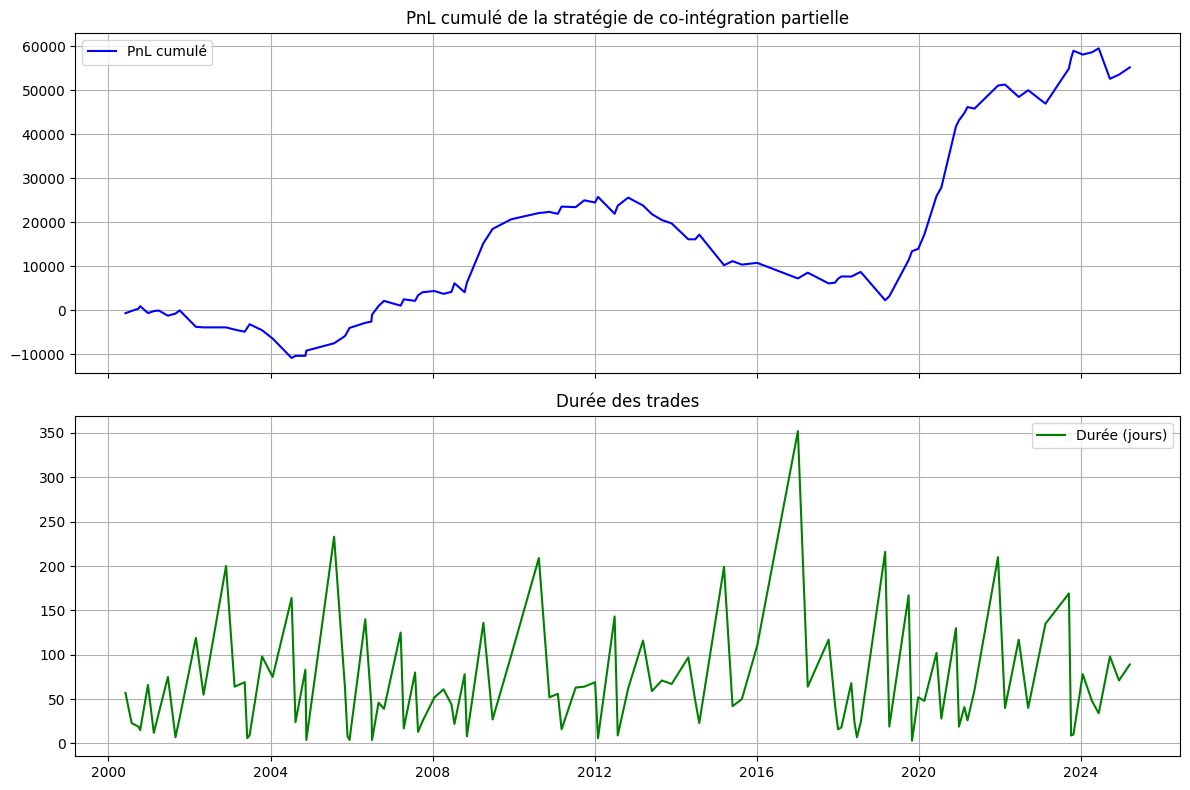

In [25]:
# PnL cumulé
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# Affichage
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Graphe 1 : PnL cumulé
ax[0].plot(trades_df["exit_date"], trades_df["cumulative_pnl"], label="PnL cumulé", color='blue')
ax[0].set_title("PnL cumulé de la stratégie de co-intégration partielle")
ax[0].grid(True)
ax[0].legend()

# Graphe 2 : Durée des trades
ax[1].plot(trades_df["exit_date"], trades_df["duration"], label="Durée (jours)", color='green')
ax[1].set_title("Durée des trades")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


In [26]:
from statsmodels.tsa.stattools import acf

# On suppose que 'spread' contient epsilon_t (spread total)
epsilon = spread.dropna()

# Moments empiriques du spread (autocorrélation)
acf_vals = acf(epsilon, nlags=3, fft=True)
v1, v2, v3 = acf_vals[1], acf_vals[2], acf_vals[3]

# Calcul de ρ (coefficient AR(1))
rho = -(v1 - 2 * v2 + v3) / (2 * v1 - v2)

# Calcul de σ²_mr
sigma2_mr = 0.5 * ((rho + 1)/(rho - 1)) * (v2 - 2*v1)

# Calcul de σ²_rw
sigma2_rw = 0.5 * (v2 - 2 * sigma2_mr)

print(f"ρ = {rho:.4f}")
print(f"σ²_mr = {sigma2_mr:.4f}")
print(f"σ²_rw = {sigma2_rw:.4f}")


ρ = 0.0001
σ²_mr = 0.5001
σ²_rw = -0.0049


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres fixés
rho = 0.1
sigma2_mr = 1.0
sigma2_rw = 0.5

# Initialisation
epsilon = spread.dropna()
n = len(epsilon)
epsilon_mr = np.zeros(n)
epsilon_rw = np.zeros(n)

# États initiaux
epsilon_mr[0] = 0
epsilon_rw[0] = epsilon.iloc[0]  # tout est attribué au random walk au départ

# Kalman Filter loop
for t in range(1, n):
    # Prediction
    epsilon_mr_pred = rho * epsilon_mr[t - 1]
    epsilon_rw_pred = epsilon_rw[t - 1]

    # Observation = epsilon_t
    eps_t = epsilon.iloc[t]
    eps_pred = epsilon_mr_pred + epsilon_rw_pred
    error = eps_t - eps_pred

    # Kalman Gain pour chaque composant (formule simplifiée et fixe)
    K_mr = sigma2_mr / (sigma2_mr + sigma2_rw)
    K_rw = sigma2_rw / (sigma2_mr + sigma2_rw)

    # Mise à jour
    epsilon_mr[t] = epsilon_mr_pred + K_mr * error
    epsilon_rw[t] = epsilon_rw_pred + K_rw * error

# Série temporelle
epsilon_mr_series = pd.Series(epsilon_mr, index=epsilon.index)
epsilon_rw_series = pd.Series(epsilon_rw, index=epsilon.index)


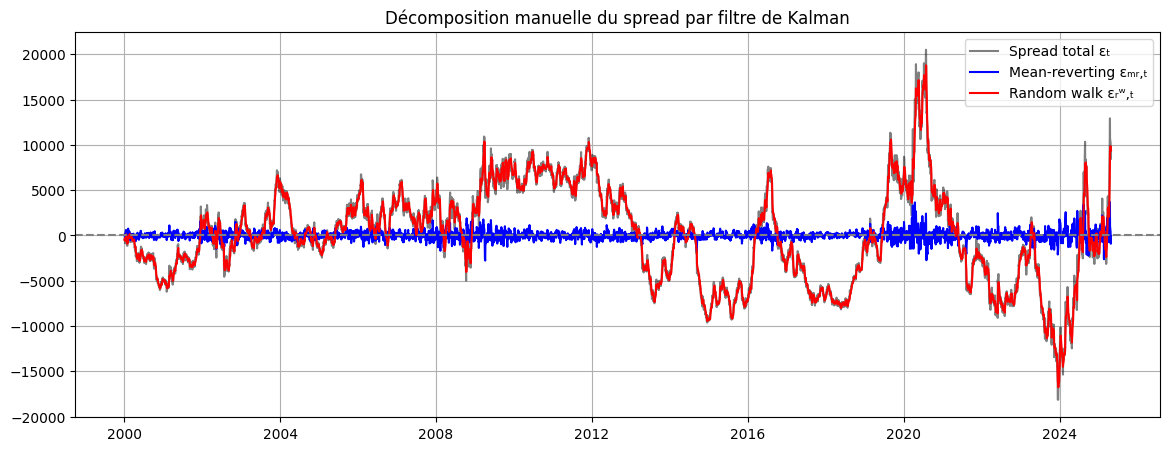

In [28]:
plt.figure(figsize=(14, 5))
plt.plot(epsilon, label="Spread total εₜ", color="black", alpha=0.5)
plt.plot(epsilon_mr_series, label="Mean-reverting εₘᵣ,ₜ", color="blue")
plt.plot(epsilon_rw_series, label="Random walk εᵣʷ,ₜ", color="red")
plt.axhline(0, color="gray", linestyle="--")
plt.legend()
plt.title("Décomposition manuelle du spread par filtre de Kalman")
plt.grid(True)
plt.show()


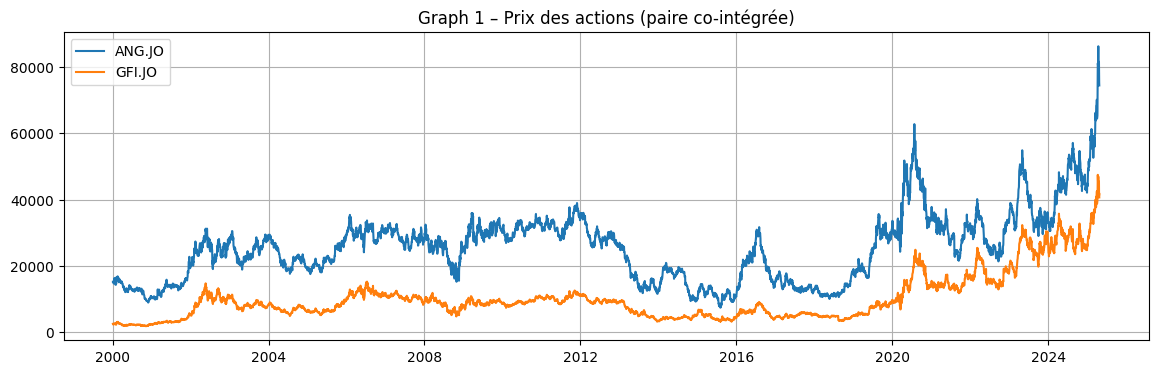

In [29]:
plt.figure(figsize=(14, 4))
plt.plot(prices["ANG.JO"], label="ANG.JO")
plt.plot(prices["GFI.JO"], label="GFI.JO")
plt.title("Graph 1 – Prix des actions (paire co-intégrée)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
entry_threshold = 1.25
exit_threshold = 0.1

# Rolling std
rolling_std = epsilon_mr_series.rolling(60).std()
threshold_high = entry_threshold * rolling_std
threshold_low = -entry_threshold * rolling_std

# Z-score simplifié (pour signal)
z_score = (epsilon_mr_series - epsilon_mr_series.rolling(60).mean()) / rolling_std

# Entrée / sortie
entry_points = []
exit_points = []
position = 0

for t in range(1, len(z_score)):
    if position == 0:
        if z_score.iloc[t] < -entry_threshold:
            position = 1
            entry_points.append((z_score.index[t], epsilon_mr_series.iloc[t]))
        elif z_score.iloc[t] > entry_threshold:
            position = -1
            entry_points.append((z_score.index[t], epsilon_mr_series.iloc[t]))
    elif position != 0 and abs(z_score.iloc[t]) < exit_threshold:
        exit_points.append((z_score.index[t], epsilon_mr_series.iloc[t]))
        position = 0


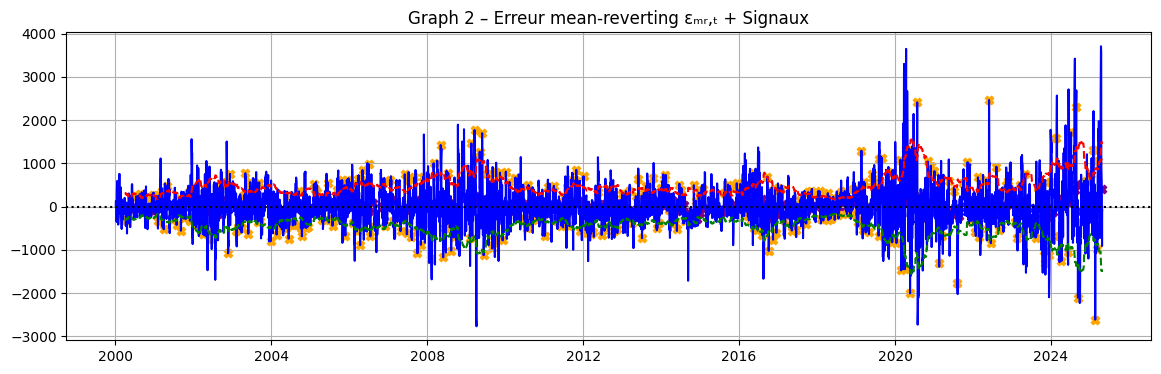

In [32]:
# Plot Graph 2
plt.figure(figsize=(14, 4))
plt.plot(epsilon_mr_series, label="Mean-reverting εₘᵣ,ₜ", color='blue')
plt.plot(threshold_high, color='red', linestyle='--', label='+1.25σ')
plt.plot(threshold_low, color='green', linestyle='--', label='-1.25σ')
plt.axhline(0, color='black', linestyle=':')

for x, y in entry_points:
    plt.scatter(x, y, color='orange', marker='X', label='Entrée')
for x, y in exit_points:
    plt.scatter(x, y, color='purple', marker='X', label='Sortie')

plt.title("Graph 2 – Erreur mean-reverting εₘᵣ,ₜ + Signaux")

plt.grid(True)
plt.show()


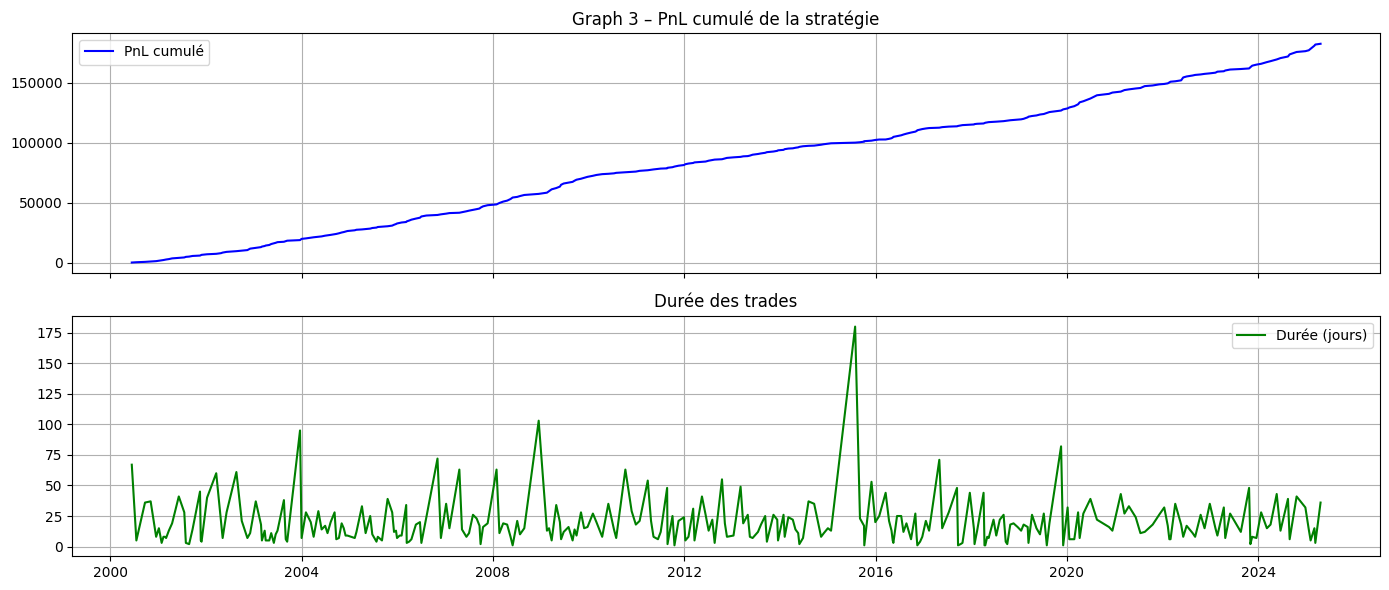

In [33]:
# Calcul PnL par trade
trades = []
position = 0
entry_date, entry_price = None, None

for t in range(1, len(z_score)):
    date = z_score.index[t]
    price = epsilon_mr_series.iloc[t]

    if position == 0:
        if z_score.iloc[t] < -entry_threshold:
            position = 1
            entry_price = price
            entry_date = date
        elif z_score.iloc[t] > entry_threshold:
            position = -1
            entry_price = price
            entry_date = date
    elif position == 1 and abs(z_score.iloc[t]) < exit_threshold:
        pnl = price - entry_price
        trades.append({'entry': entry_date, 'exit': date, 'pnl': pnl})
        position = 0
    elif position == -1 and abs(z_score.iloc[t]) < exit_threshold:
        pnl = entry_price - price
        trades.append({'entry': entry_date, 'exit': date, 'pnl': pnl})
        position = 0

# DataFrame des trades
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# Graph 3
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(trades_df["exit"], trades_df["cumulative_pnl"], label="PnL cumulé", color='blue')
ax[0].set_title("Graph 3 – PnL cumulé de la stratégie")
ax[0].legend()
ax[0].grid(True)

# Graph 3.2 – Durée des trades (bonus)
durations = [(exit - entry).days for entry, exit in zip(trades_df["entry"], trades_df["exit"])]
ax[1].plot(trades_df["exit"], durations, label="Durée (jours)", color='green')
ax[1].set_title("Durée des trades")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [34]:
kalman_gains = np.arange(0.1, 1.0, 0.1)
returns = []

for K in kalman_gains:
    # Réinitialisation
    epsilon_mr = np.zeros(len(epsilon))
    epsilon_rw = np.zeros(len(epsilon))
    epsilon_rw[0] = epsilon.iloc[0]

    for t in range(1, len(epsilon)):
        pred_mr = rho * epsilon_mr[t - 1]
        pred_rw = epsilon_rw[t - 1]
        error = epsilon.iloc[t] - (pred_mr + pred_rw)

        epsilon_mr[t] = pred_mr + K * error
        epsilon_rw[t] = pred_rw + (1 - K) * error

    # Générer le z-score
    mr_series = pd.Series(epsilon_mr, index=epsilon.index)
    rolling_std = mr_series.rolling(60).std()
    rolling_mean = mr_series.rolling(60).mean()
    z = (mr_series - rolling_mean) / rolling_std

    # Signaux
    position = pd.Series(0, index=z.index)
    position[z < -entry_threshold] = 1
    position[z > entry_threshold] = -1
    position = position.replace(to_replace=0, method="ffill")

    # PnL sur mean-reverting
    pnl = position.shift(1) * mr_series.diff()
    cumulative = pnl.cumsum()
    
    # Calcul rendement annuel moyen
    total_days = (epsilon.index[-1] - epsilon.index[0]).days
    annual_return = (cumulative[-1] / total_days) * 252  # annualisé
    returns.append(annual_return)


C:\Users\lbenzemma\AppData\Local\Temp\ipykernel_24028\1908350730.py:28: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = position.replace(to_replace=0, method="ffill")
C:\Users\lbenzemma\AppData\Local\Temp\ipykernel_24028\1908350730.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annual_return = (cumulative[-1] / total_days) * 252  # annualisé
C:\Users\lbenzemma\AppData\Local\Temp\ipykernel_24028\1908350730.py:28: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = position.replace(to_replace=0, method="ffill")
C:\Users\lbenzemma\AppData\Local\Temp\ipykernel_24028\1908350730.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.

NameError: name 'market_return_all' is not defined

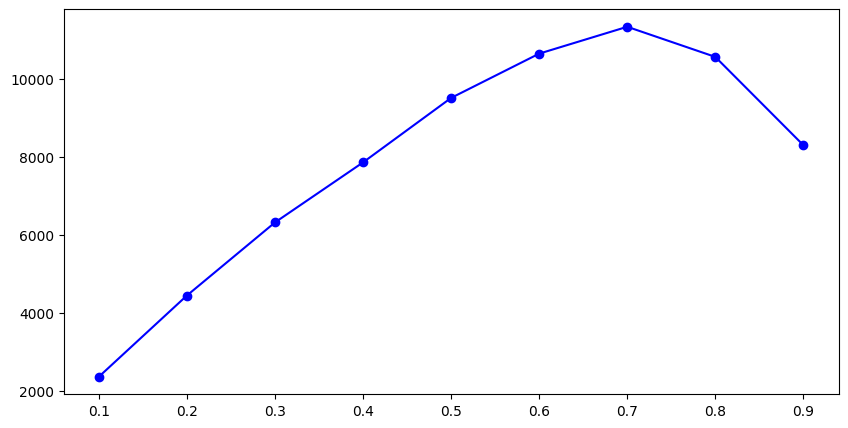

: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(kalman_gains, returns, marker='o', color='blue', label="Partial Cointegration All")
plt.axhline(y=market_return_all, color='gray', linestyle='--', label="Market All (benchmark)")  # si connu
plt.title("Kalman Gain vs Average Annual Return")
plt.xlabel("Kalman Gain K")
plt.ylabel("Return (%)")
plt.grid(True)
plt.legend()
plt.show()
